In [1]:
import sys
import numpy as np
import math
sys.path.append("../build/python")  # set to correct path for module
import varttpy

In [2]:
## IRLM model
L=100
t=0.5
V=0.15
U=-0.5

## Kinetic energy TB Hamiltonian
K=np.zeros((L,L))
for i in range(1,L-1):
    K[i,i+1]=K[i+1,i]=t

K[0,1]=K[1,0]=V

## U ni nj
Umat=np.zeros((L,L))
Umat[0,1]=U
K[0,0]=K[1,1]=-U/2

## Diagonalize the bath
ek,R = np.linalg.eigh(K[2:,2:])
iek=np.argsort([abs(x) for x in ek])
Rfull=np.identity(L)
Rfull[2:,2:]=R[:,iek]
Krot = np.transpose(Rfull) @ K @ Rfull

Vijkl={}
model = varttpy.Fermionic(Krot,Umat,Vijkl)
H=model.Ham()
print("H: ",[M.shape[-1] for M in H.cores])

H:  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]


In [3]:
sol=varttpy.DMRG(H)
sol.bond_dim=32
sol.nIter_diag=32
Npart=model.NParticle();
print("sweep energy Npart")
eners=[]
for i in range(6):
    sol.iterate()
    print(i+1, sol.energy, sol.Expectation(Npart))
    eners += [sol.energy]

variance_rel=sol.H2(4*sol.bond_dim)/sol.energy**2-1
print("H^2/E^2-1=", variance_rel)

sweep energy Npart
1 -31.24727648616172 49.95781606059562
2 -31.25015212453287 50.000000001704294
3 -31.250152196566095 49.99999999998671
4 -31.25015221608929 49.99999999997683
5 -31.25015221975285 49.99999999997525
6 -31.250152220619572 49.99999999998613
H^2/E^2-1= 3.192890396519488e-11


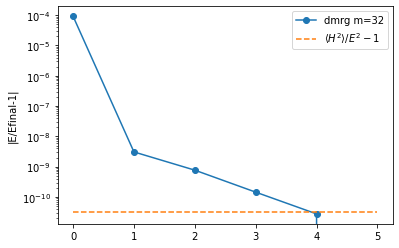

In [4]:
import matplotlib.pyplot as plt
plt.yscale('log')
eRef=np.min(eners)
plt.ylabel("|E/Efinal-1|")
plt.plot([abs(x/eRef-1) for x in eners], '-o', label=f'dmrg m={sol.bond_dim}')
plt.plot([variance_rel for x in eners], '--', label="$\\langle H^2 \\rangle /E^2-1$")
plt.legend()

In [12]:
cc=np.zeros((L,L))
for i in range(L):
    for j in range(i,L):
        cc[j,i]=cc[i,j]=sol.correlation(model.CidCj(i,j),i,j)
eval=np.sort( np.linalg.eigvals(cc) )

/home/yurielnf/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


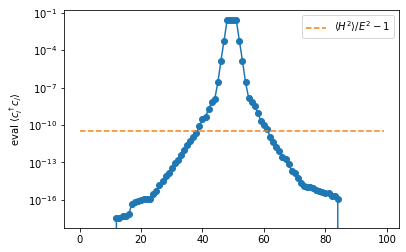

In [13]:
import matplotlib.pyplot as plt
plt.ylabel('eval $ \\langle c_i^\dagger c_j \\rangle$')
plt.yscale('log')
plt.plot([min(x,1-x) for x in eval], '-o')
plt.plot([variance_rel for x in eval], '--', label="$\\langle H^2 \\rangle /E^2-1$")
plt.legend()

In [112]:
print("Npart=",sol.Expectation(Npart))
print("H2-E^2 sigma/E")
ener=sol.Expectation(model.Ham())
m=sol.bond_dim
for mi in [m//2, m, 2*m, 3*m, 4*m]:
    print(sol.H2(mi)/ener**2-1, sol.sigma(mi)/sol.energy  )

Npart= 50.00000000048562
H2-E^2 sigma/E
1.0235330843322288e-05 -4.712154324866678e-08
4.414829901655537e-08 -3.350831552507013e-07
7.425475789801794e-10 -4.644378140984366e-06
6.145195463602704e-11 -5.957165745614695e-06
3.5922820273981415e-11 -5.993246483449609e-06


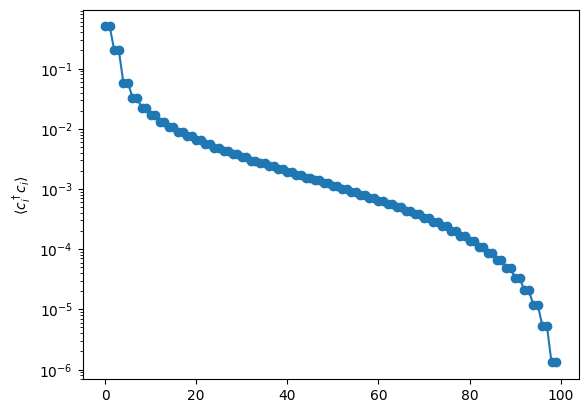

In [110]:
plt.ylabel('$ \\langle c_i^\dagger c_i \\rangle$')
plt.yscale("log")
plt.plot([min(x,1-x) for x in cc.diagonal()], 'o-')

In [14]:
print("gs: ",[M.shape[-1] for M in sol.gs.cores])

gs:  [2, 4, 8, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 31, 31, 30, 27, 26, 25, 24, 23, 22, 21, 20, 19, 17, 15, 13, 12, 7, 4, 2, 1]


In [15]:
np.savetxt(f"cc_irlm_L{L}.txt",cc)